# <center><b>Face Emotion Recognition DL Project</b></center>
# <center><b>Mostafa Eslam - 211003386</b></center>

## Including Necessary Libraries

In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np  # numpy array operations
from keras.utils import to_categorical  # convert to one-hot-encoding
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Input,
)  # layers for model
from keras.preprocessing.image import ImageDataGenerator, img_to_array  # data augmentation and image post-processing
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)  # model evaluation & confusion matrix
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # visualization
from keras.models import Model  # Model
from keras.optimizers.legacy import Adam # Optimizer
from keras.models import model_from_json # Model save/load
import cv2 # used for prediction using webcam

In [2]:
# Disable warnings
import warnings


def warn(*args, **kwargs):
    pass


warnings.warn = warn

## Loading The Data

The dataset consists of grayscale facial images, each with dimensions of 48x48 pixels. These images have been automatically adjusted to ensure the faces are centered and occupy a consistent area in each image.

### Objective:
To classify each face based on the emotion exhibited in the facial expression. The emotions are categorized into seven distinct groups:
- **0: Angry**
- **1: Disgust**
- **2: Fear**
- **3: Happy**
- **4: Sad**
- **5: Surprise**
- **6: Neutral**

### Dataset Details:
- **Training Set:** 28,709 examples
- **Public Test Set:** 3,589 examples
- **Private Test Set:** 3,589 examples

In [3]:
data = pd.read_csv("C:\\Users\\mosta\\Desktop\\DL project\\fer2013.csv") # read data

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
data.shape

(35887, 3)

In [6]:
print("Dataset Shape:", data.shape)
print("Dataset Columns:", data.columns)

Dataset Shape: (35887, 3)
Dataset Columns: Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [8]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [9]:
# Print the distribution of classes
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [10]:
# Print the number of missing values in each column
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
emotion    0
pixels     0
Usage      0
dtype: int64


In [11]:
# Creating the correlation matrix
corr_matrix = data.corr()
corr_matrix["emotion"].sort_values(ascending=False)

emotion    1.0
Name: emotion, dtype: float64

In [12]:
# Display the distribution of emotions
emotion_map = {0: 'Angry', 1: 'Disgust', 2 : 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise',6:'Neutral' }
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
# Reorder the data frame by emotion
emotion_counts = emotion_counts.sort_values('emotion')
emotion_counts

,emotion,number
0,Angry,4953
6,Disgust,547
1,Fear,5121
4,Happy,8989
3,Neutral,6198
2,Sad,6077
5,Surprise,4002


# Visualization

### Univariate Exploration

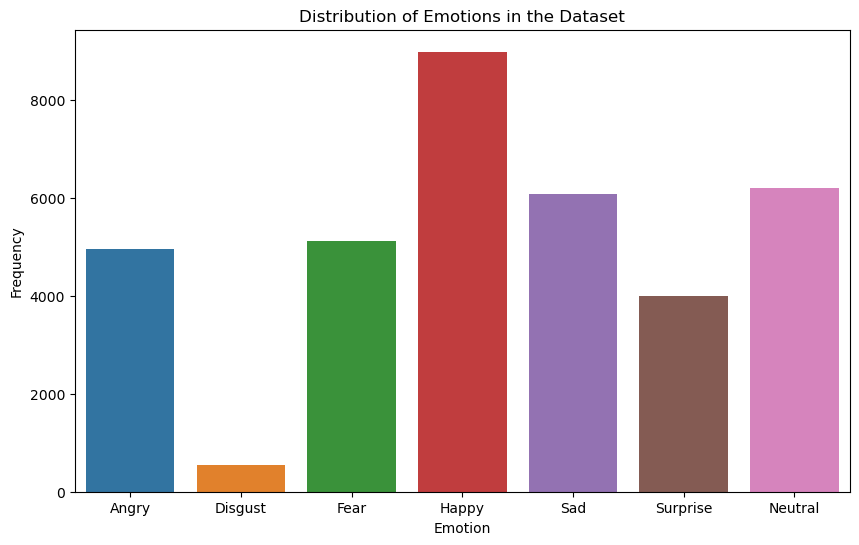

In [13]:
# Count the frequency of each emotion
emotion_counts = data['emotion'].value_counts()

# Plotting the distribution of emotions
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
# Replace the numbers with the corresponding emotion
plt.xticks(range(7), ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

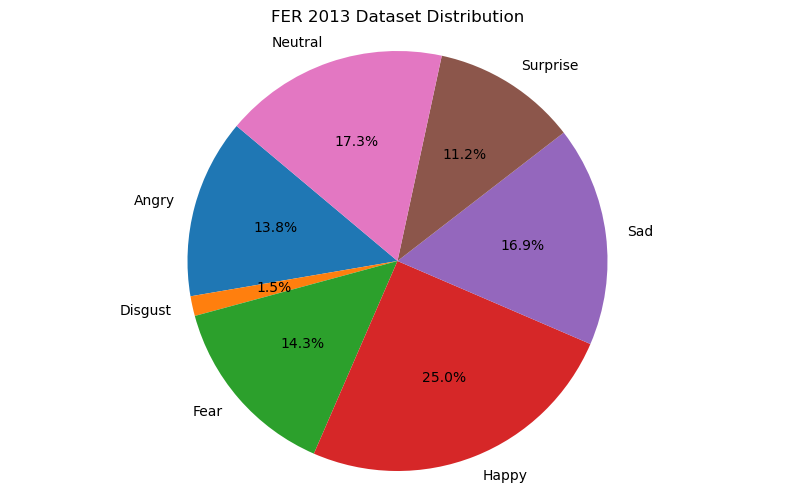

In [14]:
import matplotlib.pyplot as plt

# Data for FER 2013 dataset categories
categories = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
sizes = [4953, 547, 5121, 8989, 6077, 4002, 6198]  # Assuming these are the counts of each category in the dataset

# Creating a pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('FER 2013 Dataset Distribution')
plt.show()


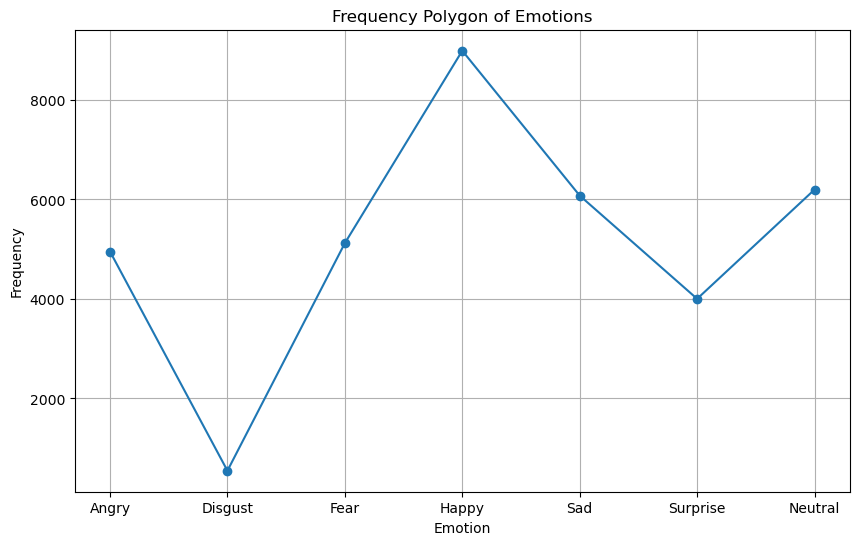

In [15]:
# Count the frequency of each emotion
emotion_counts = data['emotion'].value_counts().sort_index()

# Plotting a frequency polygon
plt.figure(figsize=(10, 6))
plt.plot(emotion_counts.index, emotion_counts.values, marker='o', linestyle='-')
plt.title('Frequency Polygon of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.grid(True)
# Replace the numbers with the corresponding emotion
plt.xticks(range(7), ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.show()


### Bivariate Exploration

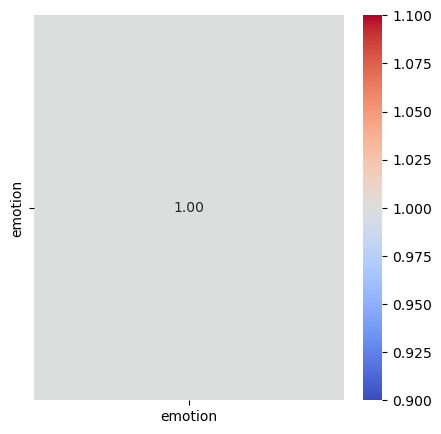

In [16]:
# Plotting the correlation matrix of the data using a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

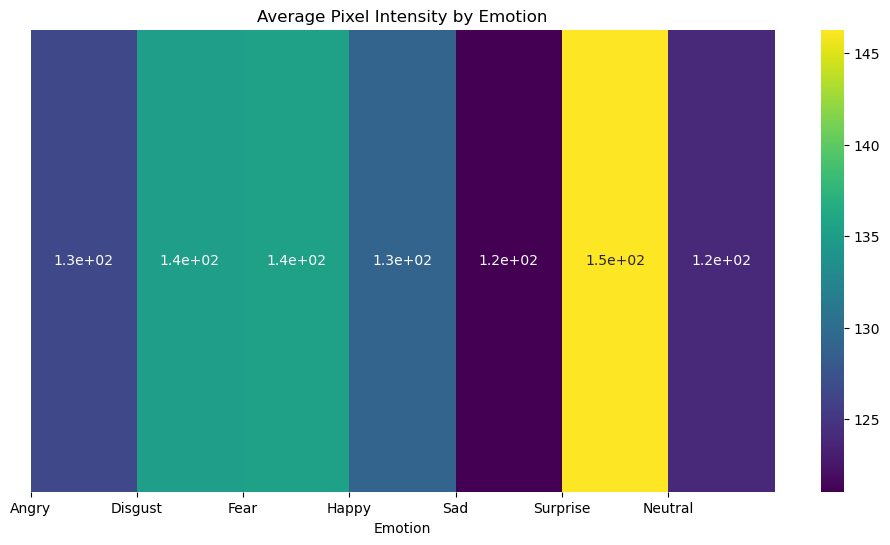

In [17]:
# Convert pixel strings to lists of integers and calculate the mean intensity
data['mean_intensity'] = data['pixels'].apply(lambda x: np.mean([int(p) for p in x.split()]))

# Group by emotion and calculate the average mean intensity
emotion_intensity = data.groupby('emotion')['mean_intensity'].mean()

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(emotion_intensity.values.reshape(1, -1), annot=True, cmap='viridis',
            xticklabels=emotion_intensity.index, yticklabels=False)
# replace the numbers with the corresponding emotion
plt.xticks(range(7), ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.title('Average Pixel Intensity by Emotion')
plt.xlabel('Emotion')
plt.show()

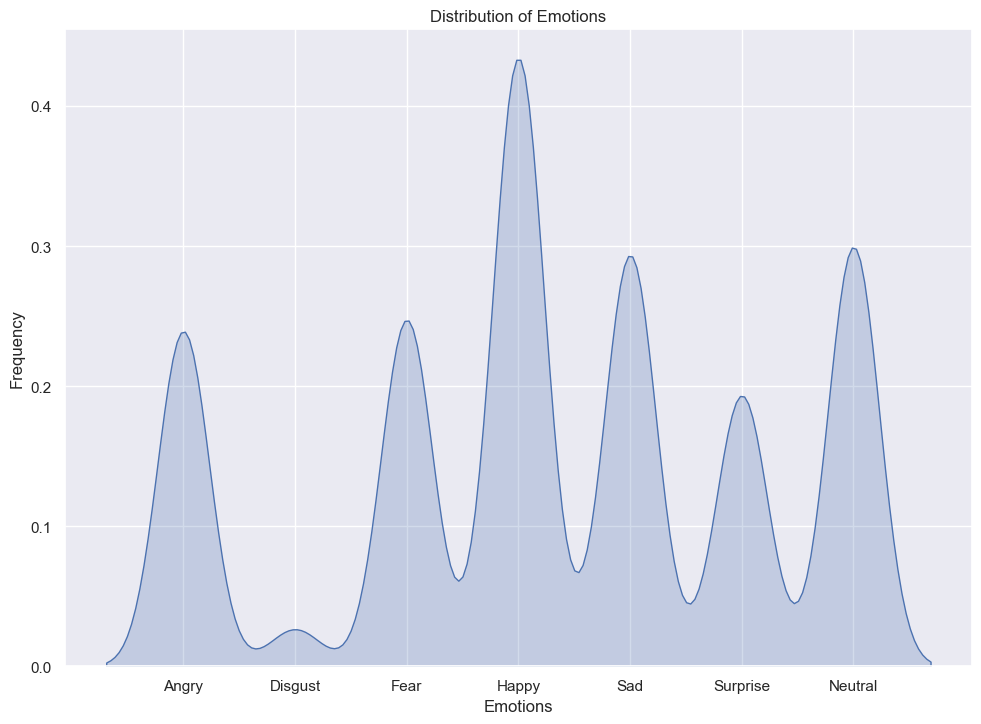

In [18]:
# Cluster analysis
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.kdeplot(data['emotion'], shade=True)
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
# Replace the numbers with the corresponding emotion
plt.xticks(range(7), ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.show()

## Preprocessing Data 


In [19]:
# Divide the data into training, validation and test sets
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []

for index, row in data.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

In [20]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [21]:
type(data["pixels"][0])

str

In [22]:
type(X_train[0])

numpy.ndarray

In [23]:
# Convert the lists to numpy arrays
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [24]:
# One-hot encode the labels
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

 ## Reshaping Data

In [25]:
# Reshape the data to 48x48 pixel images
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

 ## Building a Model using CNN

### Model Specifications
- **Input**: Grayscale images of size 48x48 pixels.

### Convolutional Layers
- The model contains **five main blocks** of convolutional layers.
- Each block includes **Conv2D layers** with ReLU activation and **BatchNormalization**.
- The number of filters increases progressively across the blocks (from 64 to 512).

### Pooling and Dropout
- Each convolutional block is followed by **MaxPooling2D** for dimensionality reduction.
- A **Dropout layer** with a rate of 0.3 is used after each pooling layer to prevent overfitting.

### Final Layers
- After convolutional blocks, the network includes a **Flatten layer**.
- A **Dense output layer** with softmax activation function for classifying into seven emotion categories.

### Model Construction and Summary
- The model is constructed using Keras' `Model` class.
- A summary of the model is printed, detailing its architecture.


In [26]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)
    
    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)
    
    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)
    
    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)
    
    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)
    
    # Create model
    model = Model(inputs =visible, outputs = ouput)
    
    # Summary of the model
    print(model.summary())
    
    return model

## Compiling the Model

In [27]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

## Image Augmentation

In [28]:
# Augment the data using ImageDataGenerator
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size = 64

In [29]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

 ## Training The Model

In [30]:
%%script false --no-raise-error

num_epochs = 40
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Couldn't find program: 'false'


 ## Save the Model

In [31]:
%%script false --no-raise-error
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights('model.h5')

Couldn't find program: 'false'


In [32]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')

## Testing the Model 

In [33]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # load the trained model for face detection
ip = "http://192.168.1.155:8080/video" # ip address of the mobile camera
cap = cv2.VideoCapture(0) # capture the video from the webcam (0) or from the mobile camera (ip)


while True:
    res, frame = cap.read() # read the frame
    if not res:
        break
    
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert the frame to gray scale
    faces = face_haar_cascade.detectMultiScale(gray_image) # detect faces in the frame

    # Display the number of faces detected
    if len(faces) == 0:
        cv2.putText(frame, "No Face Found", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    elif len(faces) > 1:
        cv2.putText(frame, "Multiple Faces Found", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Detect the emotion in the face
    elif len(faces) == 1:

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, pt1=(x, y), pt2=(x + w, y + h), color=(255, 0, 0), thickness=2) # draw a rectangle around the face
            roi_gray = gray_image[y-5:y + h+5, x-5:x + w+5] # crop the face from the frame with a margin of 5 pixels
            roi_gray = cv2.resize(roi_gray, (48, 48)) # resize the cropped face to 48x48 pixels
            image_pixels = img_to_array(roi_gray) # convert the image to an array
            image_pixels = np.expand_dims(image_pixels, axis=0) # expand the dimensions of the image to fit the model input shape
            image_pixels /= 255 # normalize the image pixels to be between 0 and 1

            predictions = model.predict(image_pixels, verbose=0) # predict the emotion in the face
            max_index = np.argmax(predictions[0]) # get the index of the emotion with the highest probability
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') # list of emotions
            emotion_prediction = emotion_detection[max_index] # get the emotion with the highest probability

            # Display the emotion prediction
            cv2.putText(frame, emotion_prediction, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow('Frame', frame)

    # Break the loop with the 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture once everything is done
cap.release()
cv2.destroyAllWindows()

In [34]:
# Test the model on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

113/113 [==============================] - 16s 139ms/step


In [35]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       467
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00       496
           3       0.25      1.00      0.40       895
           4       0.00      0.00      0.00       653
           5       0.00      0.00      0.00       415
           6       0.00      0.00      0.00       607

    accuracy                           0.25      3589
   macro avg       0.18      0.14      0.06      3589
weighted avg       0.19      0.25      0.10      3589



In [36]:
print(confusion_matrix(y_test, y_pred))

[[  1   0   0 466   0   0   0]
 [  0   0   0  56   0   0   0]
 [  0   0   0 496   0   0   0]
 [  0   0   0 895   0   0   0]
 [  0   0   0 653   0   0   0]
 [  0   0   0 415   0   0   0]
 [  0   0   0 607   0   0   0]]


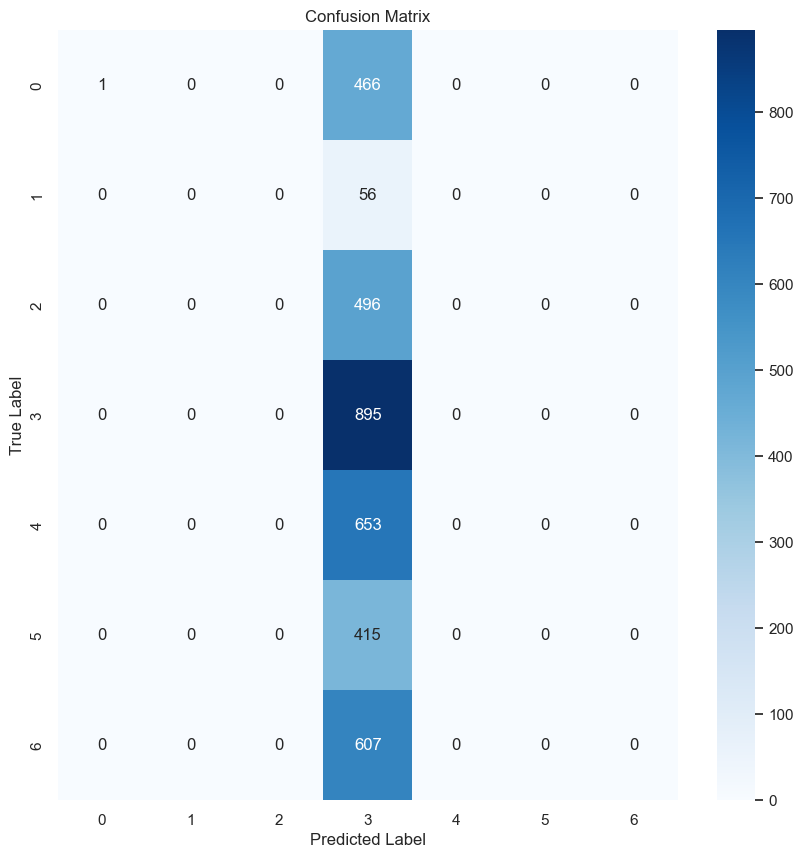

In [37]:
# confusion matrix betwen true and predicted
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')

plt.ylabel('True Label')
plt.show()

In [38]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size)

# Printing the results
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 63.92%
Test Loss: 1.0222
